# UAVSAR_PolInSAR_phase_diff_wrt_land_types
## This code calculates the InSAR phase difference of different polarimetric channels vs coherence of every selected AOI (Different land covers
### Heming Liao, hliao@alaksa.edu

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib.path import Path
import IO
import re
import matplotlib
from datetime import datetime
%run UAVSAR_InSAR_proc.ipynb

Processing data: NISARA
['190606', '190620', '190701', '190725', '190812', '190923', '190930']
['190606', '190620', '190701', '190725', '190812', '190923', '190930']
Processing data: 190606-190620
Processing data: 190606-190701
Processing data: 190606-190725
Processing data: 190606-190812
Processing data: 190606-190923
Processing data: 190606-190930
Processing data: 190620-190701
Processing data: 190620-190725
Processing data: 190620-190812
Processing data: 190620-190923
Processing data: 190620-190930
Processing data: 190701-190725
Processing data: 190701-190812
Processing data: 190701-190923
Processing data: 190701-190930
Processing data: 190725-190812
Processing data: 190725-190923
Processing data: 190725-190930
Processing data: 190812-190923
Processing data: 190812-190930
Processing data: 190923-190930


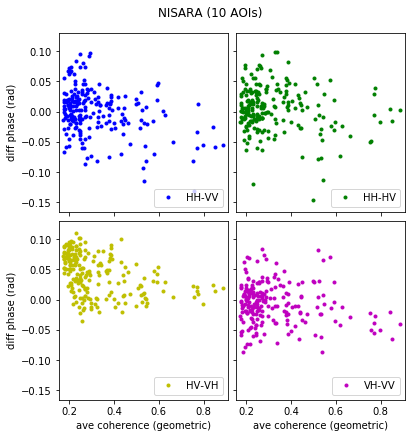

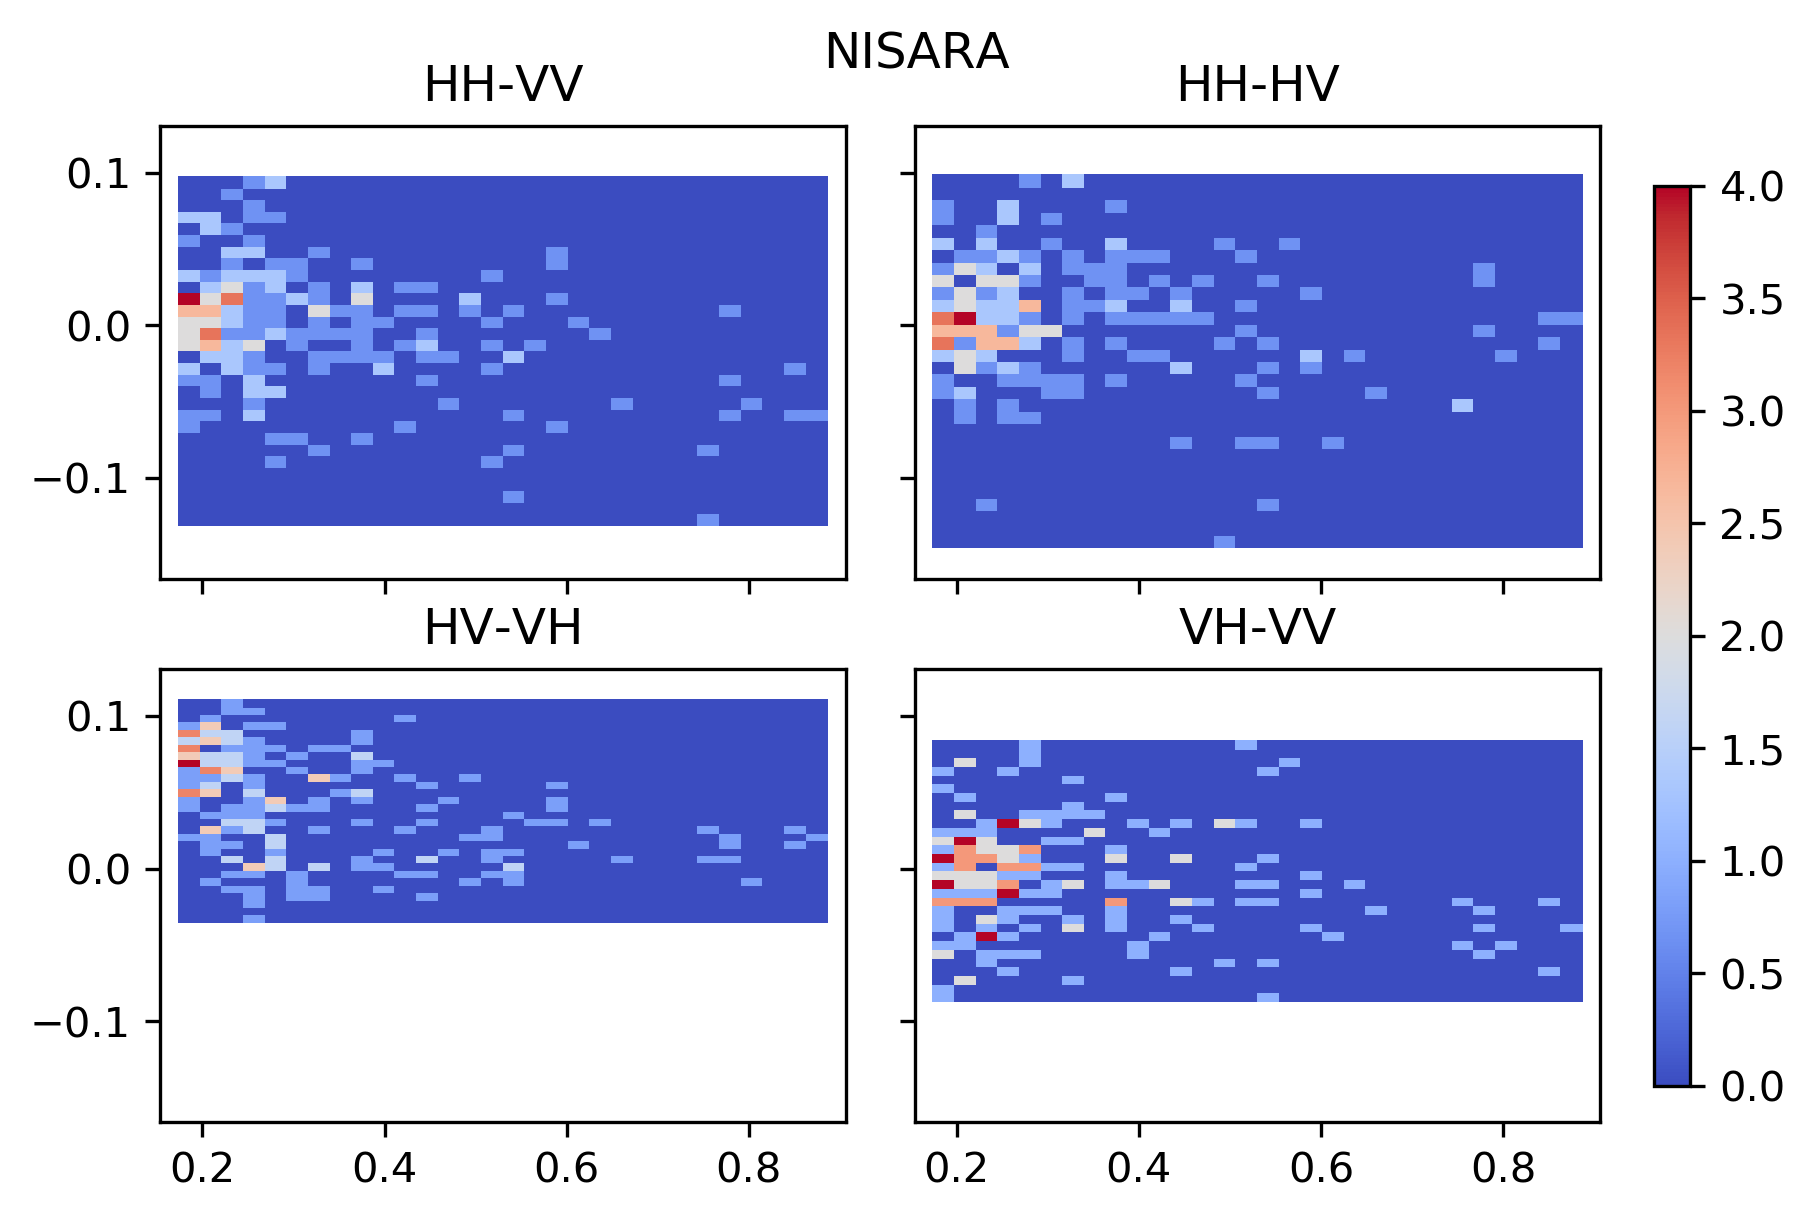

In [4]:
site_list = ('NISARA_06800','winnip_31606','SanAnd_05508','SDelta_23518')

sites_land_type = {'NISARA':['NISARA_veg1','NISARA_veg2','NISARA_veg3','NISARA_veg4','NISARA_veg5',
                            'NISARA_veg6','NISARA_veg7','NISARA_veg8','NISARA_veg9','NISARA_veg10',],
                   'SDelta':['SDelta_agr1','SDelta_agr2','SDelta_agr3','SDelta_agr4','SDelta_agr5',
                            'SDelta_agr6','SDelta_agr7','SDelta_agr8','SDelta_agr9','SDelta_agr10',], 
                   'winnip':['winnip_agr1','winnip_agr2','winnip_agr3','winnip_agr4','winnip_agr5',
                            'winnip_agr6','winnip_agr7','winnip_agr8','winnip_agr9','winnip_agr10','winnip_agr11',],
                   'SanAnd':['SanAnd_bareland1','SanAnd_bareland2','SanAnd_bareland3','SanAnd_bareland4','SanAnd_bareland5',
                            'SanAnd_bareland6','SanAnd_bareland7','SanAnd_bareland8','SanAnd_bareland9','SanAnd_bareland10']}

SLC_data_dir = '/Users/hliao/Documents/UAF_work/coherence/npy_new_data'
mask_dir = '/Users/hliao/Documents/UAF_work/coherence/AOI_mask_data'
output_dir = '/Users/hliao/Documents/UAF_work/coherence/npy_new_data_results/polInSAR_phase_diff_hist'

polarizations = ['HH','HV','VH','VV']

site_temporal_coverage = {site_list[0]:('190606','190930'), site_list[1]:('120617','120717'),
                          site_list[2]:('090908','120924'), site_list[3]:('090908','120924')}


# amplitude images of different sites
for site in site_list:
    
    print('Processing data: ' + site.split("_")[0])
    
    index = site_list.index(site)
    
    # acquisitions' date list for UAVSAR site: site
    temp = [fileName.split('/')[7].split('_')[1]
            for fileName in glob.glob(os.path.join(SLC_data_dir,site.split('_')[0]+'*.npy'))]
    acq_dates = sorted(temp)
    print(acq_dates)

    #select data between time period defined in site_temporal_coverage.
    acq_dates_dec_Num = [ datetime.timestamp(datetime.strptime(date_temp,'%y%m%d')) for date_temp in acq_dates]
    start_date_dec_Num = datetime.timestamp(datetime.strptime(site_temporal_coverage[site][0],'%y%m%d'))
    end_date_dec_Num = datetime.timestamp(datetime.strptime(site_temporal_coverage[site][1],'%y%m%d'))
    acq_dates_select = [datetime.fromtimestamp(x).strftime('%y%m%d') for x in acq_dates_dec_Num if  start_date_dec_Num <= x <= end_date_dec_Num]
    print(acq_dates_select)
    
    '''
    ########################### Image geocoordinates information ##################################
    # annotation data
    ann_file_name = [fileName.split('/')[7]
            for fileName in glob.glob(os.path.join(SLC_data_dir,site.split('_')[0]+'*.ann'))]
    print(ann_file_name)
    
    SLC_annotation = IO.UAVSARAnnotation(os.path.join(SLC_data_dir,ann_file_name[0]))
        
    corner1_lat = SLC_annotation['Segment 1 Data Approximate Corner 1'].value.split(',')[0]
    corner1_lon = SLC_annotation['Segment 1 Data Approximate Corner 1'].value.split(',')[1]
    corner2_lat = SLC_annotation['Segment 1 Data Approximate Corner 2'].value.split(',')[0]
    corner2_lon = SLC_annotation['Segment 1 Data Approximate Corner 2'].value.split(',')[1]
    corner3_lat = SLC_annotation['Segment 1 Data Approximate Corner 3'].value.split(',')[0]
    corner3_lon = SLC_annotation['Segment 1 Data Approximate Corner 3'].value.split(',')[1]
    corner4_lat = SLC_annotation['Segment 1 Data Approximate Corner 4'].value.split(',')[0]
    corner4_lon = SLC_annotation['Segment 1 Data Approximate Corner 4'].value.split(',')[1]
    
    # print the four corner's coordinates
    print(str(corner1_lon)+',',str(corner1_lat),',',str(0),
          str(corner2_lon)+',',str(corner2_lat),',',str(0),
          str(corner4_lon)+',',str(corner4_lat),',',str(0),
          str(corner3_lon)+',',str(corner3_lat),',',str(0),
          str(corner1_lon)+',',str(corner1_lat),',',str(0))
    
    # image geocoordinate
    img_geo_ul = (corner2_lon, corner2_lat)
    img_geo_ll = (corner1_lon, corner1_lat)
    img_geo_ur = (corner4_lon, corner4_lat)
    img_geo_lr = (corner3_lon, corner3_lat)
    
    ## check image information
    img_info = !gdalinfo {site.split('_')[0] + '_' + acq_dates[0] + '_amplitude.png'}
    # upperLeft [8], lowerRight [9], upperRigth [10], lowerRigth [11]
    ul = (re.split(',|\)|\(',img_info[6])[1],re.split(',|\)|\(',img_info[6])[2])
    ll = (re.split(',|\)|\(',img_info[7])[1],re.split(',|\)|\(',img_info[7])[2])
    ur = (re.split(',|\)|\(',img_info[8])[1],re.split(',|\)|\(',img_info[8])[2])
    lr = (re.split(',|\)|\(',img_info[9])[1],re.split(',|\)|\(',img_info[9])[2])
    ## georeference the image
    out_vrt = site.split('_')[0] + '_' + acq_dates[0] + '.vrt'
    #!gdal_translate -of VRT -a_srs EPSG:4326 -gcp ul[0] ul[1] img_geo_ul[0] img_geo_ul[1] \
     #   -gcp ur[0] ur[1] ima_geo_ur[0] ima_geo_ur[1] \
     #   -gcp lr[0] lr[1] ima_geo_lr[0] ima_geo_lr[1] \
     #   -gcp ll[0] ll[1] img_geo_ll[0] img_geo_ll[1] {out_fig} {out_vrt}
    !gdal_translate -of VRT -a_srs EPSG:4326 -gcp ul[0] ul[1] img_geo_ll[0] img_geo_ll[1] \
        -gcp ur[0] ur[1] ima_geo_lr[0] ima_geo_lr[1] \
        -gcp lr[0] lr[1] ima_geo_ur[0] ima_geo_ur[1] \
        -gcp ll[0] ll[1] img_geo_ul[0] img_geo_ul[1] {out_fig} {out_vrt}
    ## wrap the image
    #!gdalwarp -of VRT -t_srs EPSG:4326 {out_vrt} bluemarble2.vrt
    ## Create the tiles
    !gdal2tiles.py -p geodetic -k {out_vrt}
    
    print(ul,ur,lr,ll)
    print(img_geo_ul,img_geo_ur,img_geo_lr,img_geo_ll)
    ########################### Image geocoordinates information ##################################
    '''
    
    # load the land-cover mask
    land_cover_mask, land_cover_polygon_xx, land_cover_polygon_yy = [], [], []
    land_cover_Num = len(sites_land_type[site.split('_')[0]])
    for aoi in sites_land_type[site.split('_')[0]]:
        mask_file = os.path.join(mask_dir, aoi  + '_' + 'polygon_mask.npy')
        land_cover_mask.append( np.load(mask_file) )
            
        polygon_file = os.path.join(mask_dir, aoi + '_' + 'polygon_points.npy')
        land_cover_polygon = ( np.load(polygon_file) )
            
        land_cover_polygon_xx = land_cover_polygon[0,:]
        land_cover_polygon_yy = land_cover_polygon[1,:]
            
    # Interferometric coherence/phase and polarimetric InSAR phase difference
    InSAR_pol_diff = [(0,-1),(0,1),(1,2),(2,-1)] # HH-VV, HH-HV, HV-VH, VH-VV
    ph_diff = {'HH-VV':[], 'HH-HV':[], 'HV-VH':[], 'VH-VV':[]}
    cc_diff = []
    
    for ii in range(len(acq_dates_select)):
        for jj in range(ii+1,len(acq_dates_select)):
            print('Processing data: ' + acq_dates_select[ii] + '-' + acq_dates_select[jj])
            slc_cpx1 = np.load(os.path.join(SLC_data_dir, site.split('_')[0] + '_' + acq_dates_select[ii] + 
                            '_rg6_azi16_ML_SLC.npy'))
            slc_cpx2 = np.load(os.path.join(SLC_data_dir, site.split('_')[0] + '_' + acq_dates_select[jj] + 
                            '_rg6_azi16_ML_SLC.npy'))
            
            ## intesity image
            #intensity = slc_cpx1[:,:,0]*np.conj(slc_cpx1[:,:,0])
            #amp = 10*np.log10(intensity.real+0.0001) # add 0.001 avoid zero values
    
            #amp_sorted = sorted(set(amp.flatten()))
    
            ## display amplitude and double difference InSAR phases
            #fig1,axes = plt.subplots(nrows=1,ncols=5,figsize=(16,12))
            #img = axes[0].imshow(amp,cmap='gray', vmin=amp_sorted[int(0.05*len(amp_sorted))],
                                       #vmax=amp_sorted[int(0.95*len(amp_sorted))])
            #axes[0].set_xticklabels([])
            #axes[0].set_yticklabels([])
            #axes[0].set_title('Amplitude')
            #fig1.colorbar(img,ax=axes[0],pad=0.02,orientation='horizontal',fraction=0.046)
                
            ## draw the outline of selected land cover polygon
            #axes[0].plot(land_cover_points_xx,land_cover_points_yy,'w')
            
            cc_pols = []
            for kk in range(len(InSAR_pol_diff)):
                # different polarimetric InSAR phase difference, defined in InSAR_pol_diff
                pol_diff = polarizations[InSAR_pol_diff[kk][0]] + '-' + polarizations[InSAR_pol_diff[kk][1]]
                
                # calculate the phase difference of difference channels for selected land-cover
                phase_diff = ( phase_2SLCs(  slc_cpx1[:,:,InSAR_pol_diff[kk][0]]*np.conj(slc_cpx2[:,:,InSAR_pol_diff[kk][0]]),
                                           slc_cpx1[:,:,InSAR_pol_diff[kk][1]]*np.conj(slc_cpx2[:,:,InSAR_pol_diff[kk][1]])) )

                # calculate the mean phase difference for each AOI
                for mm in range(land_cover_Num):
                    phase_diff_ave = np.mean(phase_diff[land_cover_mask[mm]])
                    ph_diff[pol_diff].append(phase_diff_ave)
                    
            # calculate the coherence of difference channels
            for kk in range(len(polarizations)):
                cc_temp = coherence_2SLCs( slc_cpx1[:,:,kk],slc_cpx2[:,:,kk] )
                cc_pols.append( coherence_2SLCs( slc_cpx1[:,:,kk],slc_cpx2[:,:,kk] ) ) 
                
            # geometric average
            cc_geo_ave = pow(cc_pols[0]*cc_pols[1]*cc_pols[2]*cc_pols[3],1/4)
            # calculate the avegerge coherence for each AOI
            for mm in range(land_cover_Num):
                cc_diff.append( np.mean(cc_geo_ave[land_cover_mask[mm]]) )
            
                ## display the different polarization InSAR phase difference map
                #img = axes[kk+1].imshow(phase_diff,cmap='hsv',vmin = -np.pi, vmax = np.pi)
                #axes[kk+1].set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
                #axes[kk+1].set_title(polarizations[InSAR_pol_diff[kk][0]] + '-' + polarizations[InSAR_pol_diff[kk][1]])
                #axes[kk+1].plot(land_cover_points_xx,land_cover_points_yy,'w')
                #fig1.colorbar(img, ax=axes[kk+1],orientation='horizontal',fraction=0.046, pad=0.02)
            
            #plt.suptitle(site.split('_')[0] + '_' + acq_dates_select[ii] + '_' + acq_dates_select[jj])
            #fig1.subplots_adjust(left=0.04, bottom=0.04, right=0.95, top=0.96, wspace=0.01, hspace=0.01)
            #outfile = site.split('_')[0] + '_' + acq_dates_select[ii] + '_' + acq_dates_select[jj] + '_polInSAR_phase_diff.png'
            #fig1.savefig(outfile, dpi=300)
            #plt.close(fig1)
            
                        
    # display the polarimetric phase difference vs the coherence difference
    # for each AOI
    for ii in range(land_cover_Num):
        xlim_val = (min(cc_diff[ii::land_cover_Num])-0.02,max(cc_diff[ii::land_cover_Num])+0.02)
        ph_diff_all = np.concatenate((ph_diff['HH-VV'][ii::land_cover_Num], ph_diff['HV-VH'][ii::land_cover_Num], 
                                  ph_diff['HH-HV'][ii::land_cover_Num], ph_diff['VH-VV'][ii::land_cover_Num]), axis=None)
        ylim_val = [min(ph_diff_all)-0.02, max(ph_diff_all)+0.02]
        fig2,axes = plt.subplots(nrows=2,ncols=2,figsize=(6,6))
        h1=axes[0][0].plot(cc_diff[ii::land_cover_Num],ph_diff['HH-VV'][ii::land_cover_Num],'b.')
        axes[0][0].set(ylabel='diff phase (rad)',xlim=(xlim_val),ylim=(ylim_val),xticklabels=[])
        axes[0][0].legend(['HH-VV'],loc=4)
        h2=axes[0][1].plot(cc_diff[ii::land_cover_Num],ph_diff['HH-HV'][ii::land_cover_Num],'g.')
        axes[0][1].legend(['HH-HV'],loc=4)
        axes[0][1].set(xlim=(xlim_val),ylim=(ylim_val),xticklabels=[],yticklabels=[])  
        h3=axes[1][0].plot(cc_diff[ii::land_cover_Num],ph_diff['HV-VH'][ii::land_cover_Num],'y.')
        axes[1][0].set(ylabel='diff phase (rad)',xlabel='ave coherence (geometric)',xlim=(xlim_val),ylim=(ylim_val))
        axes[1][0].legend(['HV-VH'],loc=4)
        h4=axes[1][1].plot(cc_diff[ii::land_cover_Num],ph_diff['VH-VV'][ii::land_cover_Num],'m.')
        axes[1][1].set(xlabel='ave coherence (geometric)',xlim=(xlim_val),ylim=(ylim_val),yticklabels=[])
        axes[1][1].legend(['VH-VV'],loc=4)
        fig2.suptitle(sites_land_type[site.split('_')[0]][ii])
        fig2.subplots_adjust(left=0.15, bottom=0.07, right=0.95, top=0.92, wspace=0.02, hspace=0.02)
    
        outfile = sites_land_type[site.split('_')[0]][ii] + '-diff_cc_VS_diff_phase_' + site.split('_')[0] + '.png'
        fig2.savefig(os.path.join(output_dir,outfile),dpi=300)
        plt.close(fig2)
    
    # Plot all AOI together in one plot
    xlim_val = (min(cc_diff)-0.02,max(cc_diff)+0.02)
    ph_diff_all = np.concatenate((ph_diff['HH-VV'], ph_diff['HH-HV'], 
                                  ph_diff['HV-VH'], ph_diff['VH-VV']), axis=None)
    ylim_val = [min(ph_diff_all)-0.02, max(ph_diff_all)+0.02]
    fig3,axes = plt.subplots(nrows=2,ncols=2,figsize=(6,6))
    h1=axes[0][0].plot(cc_diff,ph_diff['HH-VV'],'b.')
    axes[0][0].set(ylabel='diff phase (rad)',xlim=(xlim_val),ylim=(ylim_val), xticklabels=[])
    axes[0][0].legend(['HH-VV'],loc=4)
    h2=axes[0][1].plot(cc_diff,ph_diff['HH-HV'],'g.')
    axes[0][1].legend(['HH-HV'],loc=4)
    axes[0][1].set(xlim=(xlim_val),ylim=(ylim_val),yticklabels=[],xticklabels=[]) 
    h3=axes[1][0].plot(cc_diff,ph_diff['HV-VH'],'y.')
    axes[1][0].set(ylabel='diff phase (rad)',xlabel='ave coherence (geometric)',xlim=(xlim_val),ylim=(ylim_val))
    axes[1][0].legend(['HV-VH'],loc=4)
    h4=axes[1][1].plot(cc_diff,ph_diff['VH-VV'],'m.')
    axes[1][1].set(xlabel='ave coherence (geometric)',xlim=(xlim_val),ylim=(ylim_val),yticklabels=[])
    axes[1][1].legend(['VH-VV'],loc=4)
    fig3.suptitle(site.split('_')[0] + ' (' + str(land_cover_Num) + ' AOIs)')
    fig3.subplots_adjust(left=0.15, bottom=0.07, right=0.95, top=0.92, wspace=0.05, hspace=0.05)
    
    outfile = 'All-' + site.split('_')[0] + '-diff_cc_VS_diff_phase_' + site.split('_')[0] + '.png'
    fig3.savefig(os.path.join(output_dir,outfile),dpi=300)
    
    # Plot the hist2d of all AOI in one plot
    fig4,axes = plt.subplots(nrows=2,ncols=2,dpi=300)
    img1=axes[0][0].hist2d(cc_diff, ph_diff['HH-VV'], bins=30,cmap='coolwarm');
    axes[0][0].set(title='HH-VV',xlim=(xlim_val),ylim=(ylim_val),xticklabels=[])
    #plt.colorbar(img1[3],ax=axes[0][0],orientation='horizontal')
    img2=axes[0][1].hist2d(cc_diff, ph_diff['HH-HV'], bins=30,cmap='coolwarm');
    axes[0][1].set(title='HH-HV',xlim=(xlim_val),ylim=(ylim_val),xticklabels=[],yticklabels=[])
    #plt.colorbar(img2[3],ax=axes[0][1],orientation='horizontal')
    img3=axes[1][0].hist2d(cc_diff, ph_diff['HV-VH'], bins=30,cmap='coolwarm');
    axes[1][0].set(title='HV-VH',xlim=(xlim_val),ylim=(ylim_val))
    #plt.colorbar(img3[3],ax=axes[1][0],orientation='horizontal')
    img4 = axes[1][1].hist2d(cc_diff, ph_diff['VH-VV'], bins=30,cmap='coolwarm');
    axes[1][1].set(title='VH-VV',xlim=(xlim_val),ylim=(ylim_val),yticklabels=[])
    fig4.suptitle(site.split('_')[0])
    fig4.subplots_adjust(left=0.08, bottom=0.07, right=0.88, top=0.90, wspace=0.1, hspace=0.2)
    # add a shared colorbar at the right side
    cb_ax = fig4.add_axes([0.91, 0.1, 0.02, 0.75])
    cbar = fig4.colorbar(img4[3], cax=cb_ax)
    # save the 2D histogram plot
    outfile = 'hist2d-diff_cc_VS_diff_phase_' + site.split('_')[0] + '.png'
    fig4.savefig(os.path.join(output_dir,outfile),dpi=300)
    
    # save cc_diff and ph_diff for each site
    cc_diff_out = os.path.join(output_dir,site.split('_')[0] + '-coherence-all-aoi.npy')
    #np.save(cc_diff_out,cc_diff)
    
    ph_diff_array = np.concatenate((ph_diff['HH-VV'], ph_diff['HH-HV'], 
                                    ph_diff['HV-VH'], ph_diff['VH-VV']), axis=0)
    ph_diff_out = os.path.join(output_dir,site.split('_')[0] + '-diff-phase-all-aoi.npy')
    #np.save(ph_diff_out, ph_diff_array)
    
    # display only one demo results and close all other figures
    if (index != 0):
        plt.close(fig3,fig4)    

In [ ]:
'''
site_list = ('NISARA_06800','winnip_31606','SanAnd_05508','SDelta_23518')

sites_land_type = {'NISARA':['NISARA_veg1'], 'SDelta':['SDelta_agr1'], 
                   'winnip':['winnip_agr1'],'SanAnd':['SanAnd_arid1','SanAnd_mout1']}

SLC_data_dir = '/Users/hliao/Documents/UAF_work/coherence/npy_new_data'
output_dir = '/Users/hliao/Documents/UAF_work/coherence/npy_new_data_results'

polarizations = ['HH','HV','VH','VV']

site_temporal_coverage = {site_list[0]:('190606','190930'), site_list[1]:('120617','120717'),
                          site_list[2]:('090908','120924'), site_list[3]:('090908','120924')}


# amplitude images of different sites
for site in site_list[:1]:
    
    print('Processing data: ' + site.split("_")[0])
    
    index = site_list.index(site)
    
    # acquisitions' date list for UAVSAR site: site
    temp = [fileName.split('/')[7].split('_')[1]
            for fileName in glob.glob(os.path.join(SLC_data_dir,site.split('_')[0]+'*.npy'))]
    acq_dates = sorted(temp)
    print(acq_dates)

    #select data between time period defined in site_temporal_coverage.
    acq_dates_dec_Num = [ datetime.timestamp(datetime.strptime(date_temp,'%y%m%d')) for date_temp in acq_dates]
    start_date_dec_Num = datetime.timestamp(datetime.strptime(site_temporal_coverage[site][0],'%y%m%d'))
    end_date_dec_Num = datetime.timestamp(datetime.strptime(site_temporal_coverage[site][1],'%y%m%d'))
    acq_dates_select = [datetime.fromtimestamp(x).strftime('%y%m%d') for x in acq_dates_dec_Num if  start_date_dec_Num <= x <= end_date_dec_Num]
    print(acq_dates_select)
    
    ########################### Image geocoordinates information ##################################
    # annotation data
    ann_file_name = [fileName.split('/')[7]
            for fileName in glob.glob(os.path.join(SLC_data_dir,site.split('_')[0]+'*.ann'))]
    print(ann_file_name)
    
    SLC_annotation = IO.UAVSARAnnotation(os.path.join(SLC_data_dir,ann_file_name[0]))
        
    corner1_lat = SLC_annotation['Segment 1 Data Approximate Corner 1'].value.split(',')[0]
    corner1_lon = SLC_annotation['Segment 1 Data Approximate Corner 1'].value.split(',')[1]
    corner2_lat = SLC_annotation['Segment 1 Data Approximate Corner 2'].value.split(',')[0]
    corner2_lon = SLC_annotation['Segment 1 Data Approximate Corner 2'].value.split(',')[1]
    corner3_lat = SLC_annotation['Segment 1 Data Approximate Corner 3'].value.split(',')[0]
    corner3_lon = SLC_annotation['Segment 1 Data Approximate Corner 3'].value.split(',')[1]
    corner4_lat = SLC_annotation['Segment 1 Data Approximate Corner 4'].value.split(',')[0]
    corner4_lon = SLC_annotation['Segment 1 Data Approximate Corner 4'].value.split(',')[1]
    
    # print the four corner's coordinates
    print(str(corner1_lon)+',',str(corner1_lat),',',str(0),
          str(corner2_lon)+',',str(corner2_lat),',',str(0),
          str(corner4_lon)+',',str(corner4_lat),',',str(0),
          str(corner3_lon)+',',str(corner3_lat),',',str(0),
          str(corner1_lon)+',',str(corner1_lat),',',str(0))
    
    # image geocoordinate
    img_geo_ul = (corner2_lon, corner2_lat)
    img_geo_ll = (corner1_lon, corner1_lat)
    img_geo_ur = (corner4_lon, corner4_lat)
    img_geo_lr = (corner3_lon, corner3_lat)
    
    ## check image information
    img_info = !gdalinfo {site.split('_')[0] + '_' + acq_dates[0] + '_amplitude.png'}
    # upperLeft [8], lowerRight [9], upperRigth [10], lowerRigth [11]
    ul = (re.split(',|\)|\(',img_info[6])[1],re.split(',|\)|\(',img_info[6])[2])
    ll = (re.split(',|\)|\(',img_info[7])[1],re.split(',|\)|\(',img_info[7])[2])
    ur = (re.split(',|\)|\(',img_info[8])[1],re.split(',|\)|\(',img_info[8])[2])
    lr = (re.split(',|\)|\(',img_info[9])[1],re.split(',|\)|\(',img_info[9])[2])
    ## georeference the image
    out_vrt = site.split('_')[0] + '_' + acq_dates[0] + '.vrt'
    #!gdal_translate -of VRT -a_srs EPSG:4326 -gcp ul[0] ul[1] img_geo_ul[0] img_geo_ul[1] \
     #   -gcp ur[0] ur[1] ima_geo_ur[0] ima_geo_ur[1] \
     #   -gcp lr[0] lr[1] ima_geo_lr[0] ima_geo_lr[1] \
     #   -gcp ll[0] ll[1] img_geo_ll[0] img_geo_ll[1] {out_fig} {out_vrt}
    !gdal_translate -of VRT -a_srs EPSG:4326 -gcp ul[0] ul[1] img_geo_ll[0] img_geo_ll[1] \
        -gcp ur[0] ur[1] ima_geo_lr[0] ima_geo_lr[1] \
        -gcp lr[0] lr[1] ima_geo_ur[0] ima_geo_ur[1] \
        -gcp ll[0] ll[1] img_geo_ul[0] img_geo_ul[1] {out_fig} {out_vrt}
    ## wrap the image
    #!gdalwarp -of VRT -t_srs EPSG:4326 {out_vrt} bluemarble2.vrt
    ## Create the tiles
    !gdal2tiles.py -p geodetic -k {out_vrt}
    
    print(ul,ur,lr,ll)
    print(img_geo_ul,img_geo_ur,img_geo_lr,img_geo_ll)
    ########################### Image geocoordinates information ##################################
    
    # load the land-cover mask
    mask_file = sites_land_type[site.split('_')[0]][0]  + '_' + 'polygon_mask.npy'
    land_cover_mask = np.load(mask_file)
            
    polygon_file = sites_land_type[site.split('_')[0]][0]  + '_' + 'polygon_points.npy'
    land_cover_polygon = np.load(polygon_file)
            
    land_cover_points_xx = land_cover_polygon[0,:]
    land_cover_points_yy = land_cover_polygon[1,:]
            
    # Interferometric coherence/phase and polarimetric InSAR phase difference
    InSAR_pol_diff = [(0,-1),(0,1),(1,2),(2,-1)] # HH-VV, HH-HV, HV-VH, VH-VV
    ph_diff = {'HH-VV':[], 'HH-HV':[], 'HV-VH':[], 'VH-VV':[]}
    cc_diff = []
    
    for ii in range(len(acq_dates_select)):
        for jj in range(ii+1,len(acq_dates_select)):
            print('Processing data: ' + acq_dates_select[ii] + '-' + acq_dates_select[jj])
            slc_cpx1 = np.load(os.path.join(SLC_data_dir, site.split('_')[0] + '_' + acq_dates_select[ii] + 
                            '_rg6_azi16_ML_SLC.npy'))
            slc_cpx2 = np.load(os.path.join(SLC_data_dir, site.split('_')[0] + '_' + acq_dates_select[jj] + 
                            '_rg6_azi16_ML_SLC.npy'))
            
            ## intesity image
            #intensity = slc_cpx1[:,:,0]*np.conj(slc_cpx1[:,:,0])
            #amp = 10*np.log10(intensity.real+0.0001) # add 0.001 avoid zero values
    
            #amp_sorted = sorted(set(amp.flatten()))
    
            ## display amplitude and double difference InSAR phases
            #fig1,axes = plt.subplots(nrows=1,ncols=5,figsize=(16,12))
            #img = axes[0].imshow(amp,cmap='gray', vmin=amp_sorted[int(0.05*len(amp_sorted))],
                                       #vmax=amp_sorted[int(0.95*len(amp_sorted))])
            #axes[0].set_xticklabels([])
            #axes[0].set_yticklabels([])
            #axes[0].set_title('Amplitude')
            #fig1.colorbar(img,ax=axes[0],pad=0.02,orientation='horizontal',fraction=0.046)
                
            ## draw the outline of selected land cover polygon
            #axes[0].plot(land_cover_points_xx,land_cover_points_yy,'w')
            
            cc_pols = []
            for kk in range(len(InSAR_pol_diff)):
                # different polarimetric InSAR phase difference, defined in InSAR_pol_diff
                pol_diff = polarizations[InSAR_pol_diff[kk][0]] + '-' + polarizations[InSAR_pol_diff[kk][1]]
                
                # calculate the phase difference of difference channels for selected land-cover
                phase_diff = ( phase_2SLCs(  slc_cpx1[:,:,InSAR_pol_diff[kk][0]]*np.conj(slc_cpx2[:,:,InSAR_pol_diff[kk][0]]),
                                           slc_cpx1[:,:,InSAR_pol_diff[kk][1]]*np.conj(slc_cpx2[:,:,InSAR_pol_diff[kk][1]])) )
                phase_diff_ave = np.mean(phase_diff[land_cover_mask])
                ph_diff[pol_diff].append(phase_diff_ave)
                ## display the different polarization InSAR phase difference map
                #img = axes[kk+1].imshow(phase_diff,cmap='hsv',vmin = -np.pi, vmax = np.pi)
                #axes[kk+1].set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
                #axes[kk+1].set_title(polarizations[InSAR_pol_diff[kk][0]] + '-' + polarizations[InSAR_pol_diff[kk][1]])
                #axes[kk+1].plot(land_cover_points_xx,land_cover_points_yy,'w')
                #fig1.colorbar(img, ax=axes[kk+1],orientation='horizontal',fraction=0.046, pad=0.02)
            
            #plt.suptitle(site.split('_')[0] + '_' + acq_dates_select[ii] + '_' + acq_dates_select[jj])
            #fig1.subplots_adjust(left=0.04, bottom=0.04, right=0.95, top=0.96, wspace=0.01, hspace=0.01)
            #outfile = site.split('_')[0] + '_' + acq_dates_select[ii] + '_' + acq_dates_select[jj] + '_polInSAR_phase_diff.png'
            #fig1.savefig(outfile, dpi=300)
            #plt.close(fig1)
            
            # calculate the coherence of difference channels for selected land-cover
            for kk in range(len(polarizations)):
                cc_temp = coherence_2SLCs( slc_cpx1[:,:,kk],slc_cpx2[:,:,kk] )
                cc_pols.append( coherence_2SLCs( slc_cpx1[:,:,kk],slc_cpx2[:,:,kk] ) ) 
            
            # geometric average
            cc_geo_ave = pow(cc_pols[0]*cc_pols[1]*cc_pols[2]*cc_pols[3],1/4)
            cc_diff.append( np.mean(cc_geo_ave[land_cover_mask]) )
                        
    # display the polarimetric phase difference vs the coherence difference
    xlim_val = (min(cc_diff)-0.02,max(cc_diff)+0.02)
    ph_diff_all = np.concatenate((ph_diff['HH-VV'], ph_diff['HV-VH'], 
                                  ph_diff['HH-HV'], ph_diff['VH-VV']), axis=None)
    ylim_val = [min(ph_diff_all)-0.02, max(ph_diff_all)+0.02]
    fig2,axes = plt.subplots(nrows=2,ncols=2,figsize=(6,6))
    h1=axes[0][0].plot(cc_diff,ph_diff['HH-VV'],'b.')
    axes[0][0].set(ylabel='diff phase (rad)',xlim=(xlim_val),ylim=(ylim_val))
    axes[0][0].legend(['HH-VV'],loc=4)
    h3=axes[1][0].plot(cc_diff,ph_diff['HV-VH'],'y.')
    axes[1][0].set(ylabel='diff phase (rad)',xlabel='ave coherence (geometric)')
    axes[1][0].legend(['HV-VH'],loc=4)
    h2=axes[0][1].plot(cc_diff,ph_diff['HH-HV'],'g.')
    axes[0][1].legend(['HH-VH'],loc=4)
    axes[0][1].set(xlim=(xlim_val),ylim=(ylim_val), xticklabels=[],yticklabels=[])    
    h4=axes[1][1].plot(cc_diff,ph_diff['VH-VV'],'m.')
    axes[1][1].set(xlabel='ave coherence (geometric)',xlim=(xlim_val),ylim=(ylim_val))
    axes[1][1].legend(['VH-VV'],loc=4)
    fig2.suptitle(site.split('_')[0])
    fig2.subplots_adjust(left=0.15, bottom=0.07, right=0.95, top=0.92, wspace=0.25, hspace=0.15)
    
    outfile = '3-diff_cc_VS_diff_phase_' + site.split('_')[0] + '.png'
    fig2.savefig(os.path.join(output_dir,outfile),dpi=300)
'''